# MATH123-HW3
Ethan Harvey

In [1]:
import numpy as np
import pandas as pd

from scipy.spatial.distance import cdist

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Question 2
(a)

In [2]:
def kmeans(data, n_clusters):
    centroids = []
    # randomly initialize first centroid
    index = np.random.randint(len(data))
    centroids.append(data[index,:])
    new_data = np.delete(data, [index], axis=0)
    
    # initialize other centroids using farthest heuristic
    for _ in range(n_clusters-1):
        distances = np.min(cdist(new_data, centroids, 'euclidean'), axis=1)
        # get first index of datapoint with max min distance
        index = np.where(distances == max(distances))[0][0]
        centroids.append(new_data[index,:])
        new_data = np.delete(new_data, [index], axis=0)
    
    # iterate
    centroids = np.array(centroids)
    old_centroids = np.array([np.array([0,0]) for i in range(n_clusters)])
    
    
    while not np.all(old_centroids-centroids == 0):
        distances = cdist(data, centroids, 'euclidean')**2
        labels = np.argmin(distances, axis=1)
        # update centroids
        old_centroids = centroids
        centroids = np.array([np.average(data[labels==cluster],axis=0) for cluster in range(n_clusters)])        
        
    return centroids, labels

(b)

In [3]:
def centered_and_scaled(X):
    centered = np.array([X[:,i]-X[:,i].mean() for i in range(X.shape[1])]).T
    scaled = np.array([centered[:,i]/centered[:,i].std() if not centered[:,i].std() == 0 else centered[:,i] for i in range(X.shape[1])]).T
    return scaled

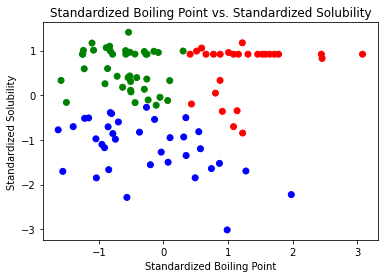

In [4]:
# load .csv
data = pd.read_csv("solvents.csv")[["BoilingPoint","Solubility"]].to_numpy()
# center and scale data
data  = centered_and_scaled(data)
_, labels = kmeans(data, 3)
colors = ['red','green','blue']
colors = [colors[labels[index]] for index in range(len(labels))]
plt.scatter(data[:,0], data[:,1], color=colors)
plt.xlabel("Standardized Boiling Point")
plt.ylabel("Standardized Solubility")
plt.title("Standardized Boiling Point vs. Standardized Solubility")
plt.show()

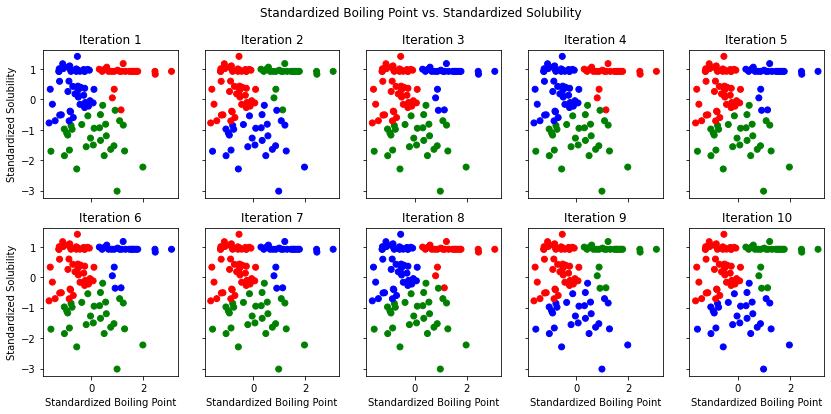

In [5]:
figure, axis = plt.subplots(2, 5, figsize=(14, 6), sharex=True, sharey=True)
for i in range(10):
    _, labels = kmeans(data, 3)
    # save results
    colors = ['red','green','blue']
    colors = [colors[labels[index]] for index in range(len(labels))]
    axis[int(i/5),i%5].scatter(data[:,0], data[:,1], color=colors)
    axis[int(i/5),i%5].set_title("Iteration "+str(i+1))
    # axis titles
    if int(i/5) == 1:
        axis[int(i/5),i%5].set_xlabel("Standardized Boiling Point")
    if i%5 == 0:
        axis[int(i/5),i%5].set_ylabel("Standardized Solubility")
# figure title
figure.suptitle("Standardized Boiling Point vs. Standardized Solubility")
figure.show()

The data points do not all belong to the exact same cluster every time the algorithm is run. This is because we randomly initialized the first centroid and so our centroids are not guarenteed to be the same each time the algorithm is run.

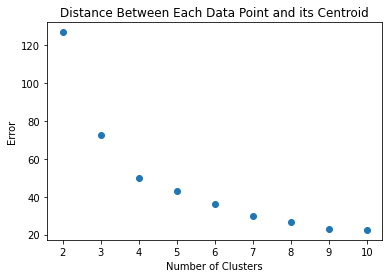

In [6]:
errors = []
for n_clusters in [2,3,4,5,6,7,8,9,10]:
    centroids, labels = kmeans(data, n_clusters)
    distance = cdist(data, centroids, 'euclidean')
    minimum_distance = np.amin(distance, axis=1)
    errors.append(sum(minimum_distance**2))
plt.scatter([2,3,4,5,6,7,8,9,10], errors)
plt.ylabel("Error")
plt.xlabel("Number of Clusters")
plt.title("Distance Between Each Data Point and its Centroid")
plt.show()

As the number of clusters increases the error dercreases. The decrease in error is much more significant the fewer clusters there are. A good number of clusters is 4 or 5, since the decrease in error is much more significant before this point than after. This point is called the elbow curve.

### Question 3
(a)

In [7]:
def project_data(X, number_components):
    X = centered_and_scaled(X)
    cov_matrix = (1/len(X))*X.T@X
    eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:,idx]
    pca_vectors = eigen_vectors[:,:number_components]
    X_pca = X@pca_vectors
    return X_pca

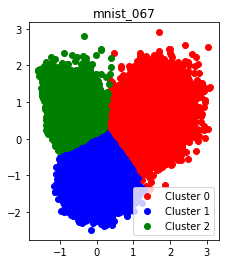

In [8]:
import scipy.io
from sklearn.cluster import KMeans
X = scipy.io.loadmat('mnist_067.mat')['data_067']
X_pca = project_data(X, 2)
# 100 replicates on the latent representations
kmeans = KMeans(n_clusters=3, n_init=100).fit(np.real(X_pca))
plt.scatter(centered_and_scaled(X_pca)[kmeans.labels_==0,0], 
            centered_and_scaled(X_pca)[kmeans.labels_==0,1], 
            color="red", label="Cluster 0")
plt.scatter(centered_and_scaled(X_pca)[kmeans.labels_==1,0], 
            centered_and_scaled(X_pca)[kmeans.labels_==1,1], 
            color="blue", label="Cluster 1")
plt.scatter(centered_and_scaled(X_pca)[kmeans.labels_==2,0], 
            centered_and_scaled(X_pca)[kmeans.labels_==2,1], 
            color="green", label="Cluster 2")
plt.gca().set_aspect('equal')
plt.title("mnist_067")
plt.legend()
plt.show()

(b)

Given the results from problem 6 in HW3, we could conclude that each cluster represents a digit 0, 6, or 7 from the mnist dataset. This classification would have a relatively high accuracy for predicting each digit since the graphs are similar.